<a href="https://colab.research.google.com/github/vijayantony961/OBSIP/blob/main/retails_sales_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_csv('/content/retail_sales_dataset[1].csv')

In [3]:
df.shape

(1000, 9)

In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
print(df['gender'].value_counts(), '\n')
print(df['product_category'].value_counts())

gender
Female    510
Male      490
Name: count, dtype: int64 

product_category
Clothing       351
Electronics    342
Beauty         307
Name: count, dtype: int64


In [7]:
print(df.customer_id.value_counts().max())

1


In [8]:
np.random.seed(101)

df['customer_id_new'] = np.random.randint(0, 500, size=1000)
df.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,customer_id_new
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150,351
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000,11
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30,337
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500,326
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100,63


In [9]:
df.customer_id_new.value_counts()

customer_id_new
343    7
383    7
215    6
133    6
66     6
      ..
354    1
72     1
48     1
130    1
60     1
Name: count, Length: 429, dtype: int64

In [10]:
df['customer_id_new'] = df['customer_id_new'].apply(lambda x: f'CUST{str(x).zfill(3)}')

In [11]:
df['customer_id'] = df['customer_id_new']
df.head()

,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount,customer_id_new
0,1,2023-11-24,CUST351,Male,34,Beauty,3,50,150,CUST351
1,2,2023-02-27,CUST011,Female,26,Clothing,2,500,1000,CUST011
2,3,2023-01-13,CUST337,Male,50,Electronics,1,30,30,CUST337
3,4,2023-05-21,CUST326,Male,37,Clothing,1,500,500,CUST326
4,5,2023-05-06,CUST063,Male,30,Beauty,2,50,100,CUST063


In [12]:
df = df.drop(columns=['customer_id_new'])
df.customer_id.value_counts().head()

customer_id
CUST343    7
CUST383    7
CUST215    6
CUST133    6
CUST066    6
Name: count, dtype: int64

In [13]:
max_date = df['date'].max()
max_date

Timestamp('2024-01-01 00:00:00')

In [14]:
customer_data = df.groupby('customer_id').agg({
    'date': lambda x: (max_date - x.max()).days,  # recency
    'transaction_id': 'count',  # frequency
    'total_amount': 'sum'  # monetary
})

In [15]:
customer_data.rename(columns={
    'date': 'recency',
    'transaction_id': 'frequency',
    'total_amount': 'monetary'
}, inplace=True)

customer_data.head()

,recency,frequency,monetary
customer_id,,,
CUST000,325,2,800
CUST001,56,2,1800
CUST002,91,2,250
CUST003,292,2,1090
CUST004,81,3,1210


In [16]:
quantiles = customer_data.quantile(q=[.25, .5, .75])
quantiles = quantiles.to_dict()

In [17]:
quantiles

{'recency': {0.25: 45.0, 0.5: 105.0, 0.75: 202.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'monetary': {0.25: 175.0, 0.5: 920.0, 0.75: 1575.0}}

In [18]:
def RScore(x, a, b):
    if x <= a:
        return 5
    elif a < x <= b:
        return 4
    elif b < x <= quantiles['monetary'][0.75]:
        return 3
    elif quantiles['monetary'][0.75] < x <= quantiles['frequency'][0.75]:
        return 2
    else:
        return 1

def FMScore(x, a, b): # frequency and monetary: higher better
    if x <= a:
        return 1
    elif a < x <= b:
        return 2
    elif b < x <= quantiles['frequency'][0.75]:
        return 3
    elif quantiles['frequency'][0.75] < x <= quantiles['monetary'][0.75]:
        return 4
    else:
        return 5

In [19]:
customer_data['R_Score'] = customer_data['recency'].apply(RScore, args=(quantiles['recency'][0.25], quantiles['recency'][0.5]))
customer_data['F_Score'] = customer_data['frequency'].apply(FMScore, args=(quantiles['frequency'][0.25], quantiles['frequency'][0.5]))
customer_data['M_Score'] = customer_data['monetary'].apply(RScore, args=(quantiles['monetary'][0.25], quantiles['monetary'][0.5]))

In [20]:
customer_data['RFM_Score'] = customer_data['R_Score'].astype(str) + customer_data['F_Score'].astype(str) + customer_data['M_Score'].astype(str)
customer_data.head()

,recency,frequency,monetary,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
CUST000,325,2,800,3,2,4,324
CUST001,56,2,1800,4,2,1,421
CUST002,91,2,250,4,2,4,424
CUST003,292,2,1090,3,2,3,323
CUST004,81,3,1210,4,3,3,433


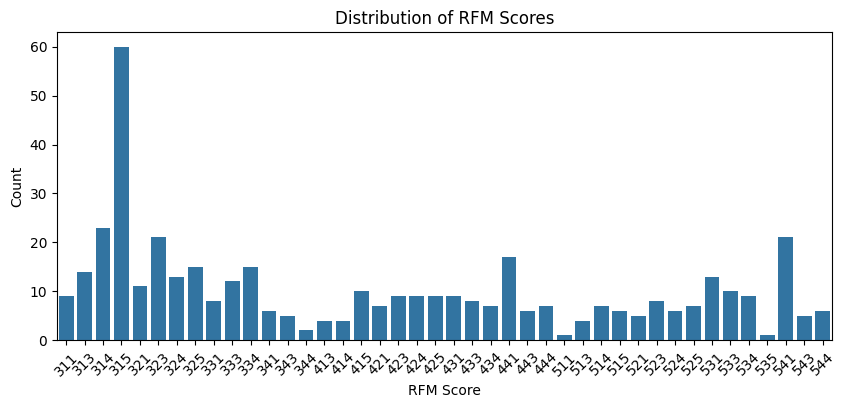

In [21]:
plt.figure(figsize=(10,4))
rfm_level_counts = customer_data['RFM_Score'].value_counts().sort_index()
sns.barplot(x=rfm_level_counts.index, y=rfm_level_counts.values)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

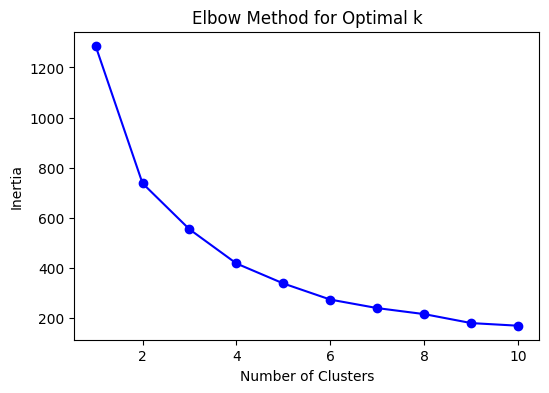

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(customer_data[['R_Score', 'F_Score', 'M_Score']])

inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# elbow curve to choose optimal clusters
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [23]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
cluster_summary = customer_data.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [25]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,3.072917,2.541667,2.322917
1,1,4.570175,2.377193,3.833333
2,2,3.125874,1.195804,4.468531
3,3,4.578947,3.578947,1.289474


In [26]:
segment_names = {
    0: 'At Risk',
    1: 'Recent Customers',
    2: 'Big Spenders',
    3: 'Frequent Low Spenders'
}

# Assign the segment names to the Cluster
customer_data['Segment'] = customer_data['Cluster'].map(segment_names)

# Display the customer data with segments
customer_data[['R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Cluster', 'Segment']].head()

,R_Score,F_Score,M_Score,RFM_Score,Cluster,Segment
customer_id,,,,,,
CUST000,3,2,4,324,2,Big Spenders
CUST001,4,2,1,421,0,At Risk
CUST002,4,2,4,424,1,Recent Customers
CUST003,3,2,3,323,0,At Risk
CUST004,4,3,3,433,1,Recent Customers


In [27]:
segment_size = customer_data['Segment'].value_counts().reset_index()
segment_size.columns = ['Segment','Count']
segment_size

,Segment,Count
0,Big Spenders,143
1,Recent Customers,114
2,At Risk,96
3,Frequent Low Spenders,76


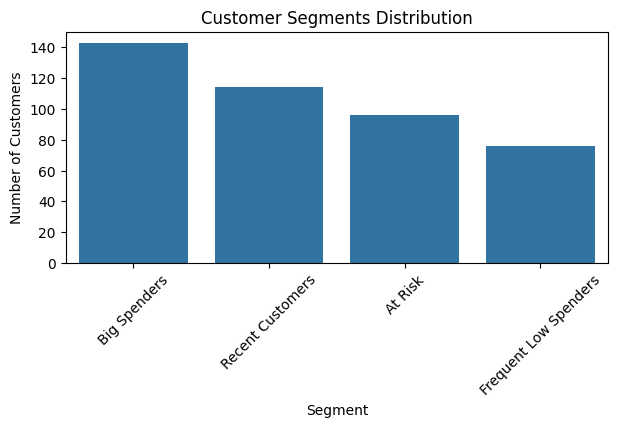

In [28]:
plt.figure(figsize=(7,3))
sns.countplot(data=customer_data, x='Segment', order=segment_size['Segment'])
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()